In [ ]:
!nvidia-smi

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Pytorch

In [ ]:
x = torch.randn(2, 3)
w = torch.randn(3, 5, requires_grad=True)
b = torch.randn(1, 5, requires_grad=True)

out = torch.matmul(x, w) + b
l = out.mean()

print(w.grad)
l.backward()
print(w.grad)

# Dataset

In [ ]:
import torchvision

In [ ]:
mnist_train_dataset = torchvision.datasets.MNIST('/mnist_data/', train=True, download=True)
mnist_test_dataset = torchvision.datasets.MNIST('/mnist_data/', train=False, download=True)

In [ ]:
import matplotlib.pyplot as plt

SUBPLOT_ROWS = 3
SUBPLOT_COLS = 3

fig, ax = plt.subplots(SUBPLOT_ROWS, SUBPLOT_COLS)
fig.tight_layout()

for i in range(SUBPLOT_ROWS):
  for j in range(SUBPLOT_COLS):
    img, label = mnist_train_dataset[i * SUBPLOT_COLS + j]
    ax[i,j].imshow(img, cmap='gray_r')
    ax[i,j].set_title(f'LABEL : {label}')

plt.show()

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        return image, label

In [ ]:
VAL_PERCENTAGE = 0.05

# Split train in train and validation
val_size = int(VAL_PERCENTAGE * len(mnist_train_dataset))
train_size = len(mnist_train_dataset) - val_size

val_set, train_set = torch.utils.data.random_split(mnist_train_dataset, [val_size, train_size])

print(f'Before split: {len(mnist_train_dataset)}')
print(f'After split: {len(val_set)}(val) + {len(train_set)}(train)')

In [ ]:
# (Image, label)
print(mnist_train_dataset[0])

In [ ]:
# Convert images to tensors
mnist_train_dataset = torchvision.datasets.MNIST('/mnist_data/', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test_dataset = torchvision.datasets.MNIST('/mnist_data/', train=False, download=True, transform=torchvision.transforms.ToTensor())

In [ ]:
print(mnist_train_dataset[0])

In [ ]:
print(mnist_train_dataset[0][0].shape)

# Data loader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(mnist_test_dataset, batch_size=64, num_workers=2)

In [ ]:
for example in train_dataloader:
  print(example)
  print(example[0].shape)
  break

# MLP

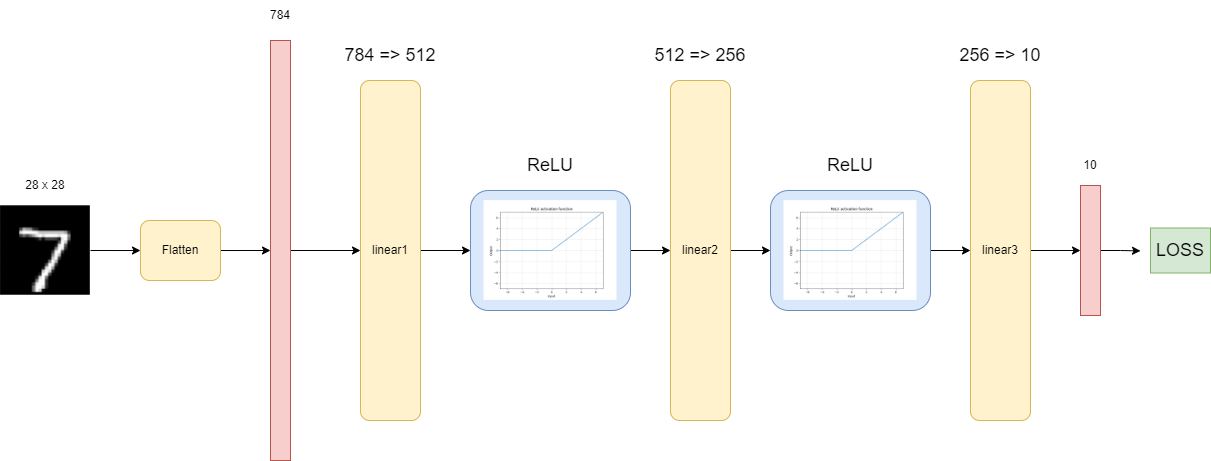

In [ ]:
class MLPModel(nn.Module):
  def __init__(self, img_dims=(28, 28), num_classes=10):
    super(MLPModel, self).__init__()
    self.linear1 = nn.Linear(img_dims[0] * img_dims[1], 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, num_classes)

  def forward(self, x):
    # Flatten the image: B x 1 x R x C => B x RC
    x = torch.flatten(x, start_dim=-3)

    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)

    return x

In [ ]:
mlp_model_alt = nn.Sequential(
                        nn.Flatten(start_dim=-3),
                        nn.Linear(28 * 28, 512), 
                        nn.ReLU(), nn.Linear(512, 256), 
                        nn.ReLU(), 
                        nn.Linear(256, 10)
                ) 

# Convolution

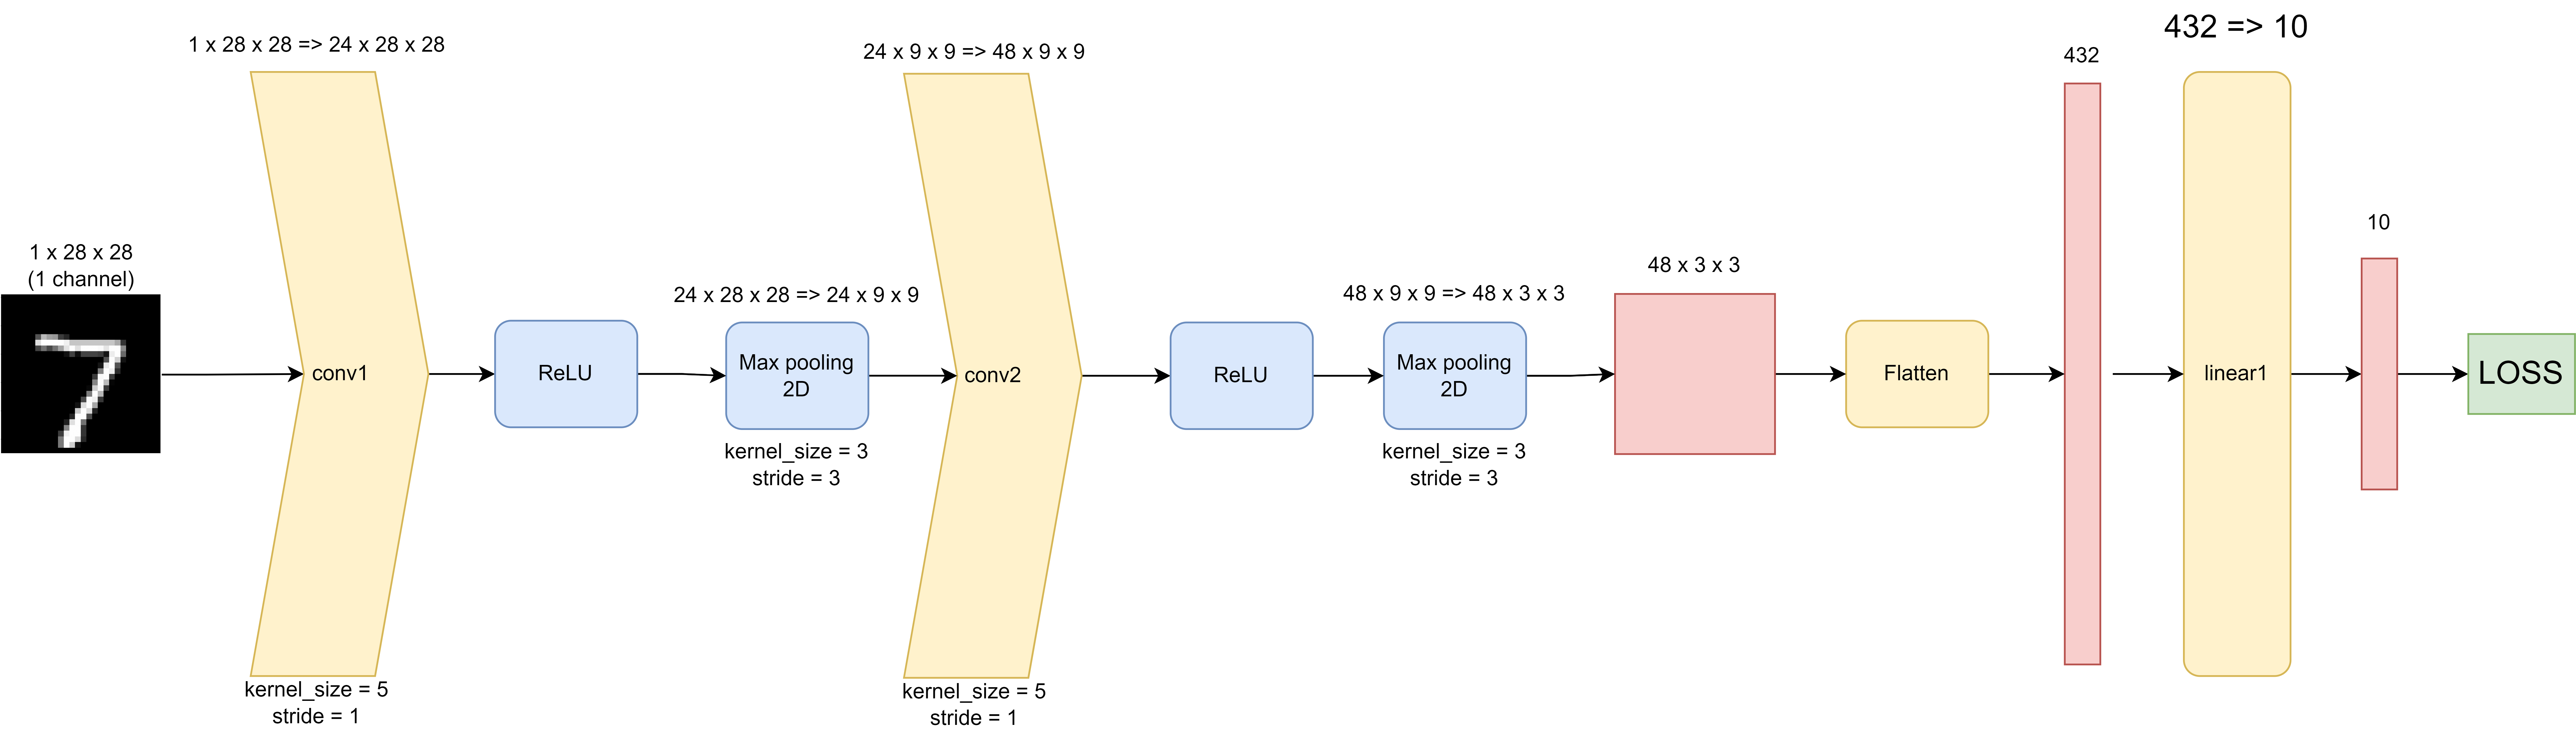

In [ ]:
class ConvModel(nn.Module):
  def __init__(self, img_dims=(28, 28), pool_kernel_size=3, num_classes=10):
    super(ConvModel, self).__init__()

    self.pool_kernel_size = pool_kernel_size

    self.conv1 = nn.Conv2d(1, 24, 5, 1, padding='same')
    self.conv2 = nn.Conv2d(24, 48, 5, 1, padding='same')

    self.linear1 = nn.Linear(48 * (img_dims[0]//pool_kernel_size**2) * (img_dims[1]//pool_kernel_size**2), 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, self.pool_kernel_size, self.pool_kernel_size)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, self.pool_kernel_size, self.pool_kernel_size)
    
    x = torch.flatten(x, start_dim=-3)

    x = self.linear1(x)

    return x

In [ ]:
conv_model_alt = nn.Sequential(
                      nn.Conv2d(1, 24, 5, 1, padding='same'),
                      nn.ReLU(),
                      nn.MaxPool2d(3, 3),
                      nn.Conv2d(24, 48, 5, 1, padding='same'),
                      nn.ReLU(),
                      nn.MaxPool2d(3, 3),
                      nn.Linear(48 * (28 // 9) * (28 // 9), 256),
                      nn.ReLU(),
                      nn.Linear(256, 10)
                )

# Training

In [ ]:
from tqdm import tqdm

In [ ]:
!pip install wandb -qqq
import wandb

In [ ]:
def train(model, train_dataloader, test_dataloader, num_epochs=1, lr=1e-3, log_every_n_step=150):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  #with wandb.init(project="UZOP_LAB"):
  #model.cuda(0)

  # TRAINING
  model.train()

  for epoch in range(num_epochs):
    with tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Training (epoch={epoch}/{num_epochs})') as epoch_progress:
      for batch_idx, train_batch in epoch_progress:
        x, y = train_batch
        #x = x.cuda(0)
        #y = y.cuda(0)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        epoch_progress.set_postfix({'loss': loss.item()})

        # Log training metrics
        # if (epoch * len(train_dataloader) + batch_idx) % log_every_n_step == 0:
        #   wandb.log({"train/loss": loss})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # TEST
  model.eval()
  with torch.no_grad():
    test_loss = []
    correct = 0
    count = 0

    for test_batch in tqdm(test_dataloader, desc="Testing"):
      x, y = test_batch
      #x = x.cuda(0)
      #y = y.cuda(0)
      logits = model(x)
      loss = F.cross_entropy(logits, y)
      test_loss.append(loss)
      correct += (logits.argmax(dim=-1) == y).float().sum()
      count += len(y)

    test_loss = torch.mean(torch.tensor(test_loss))
    test_acc = correct / count

    # Log test metrics
    # wandb.log({"test/loss": test_loss, "test/acc": test_acc})

    print()
    print(f"--- TEST ---")
    print("loss: ", test_loss.item())
    print("accuracy: ", test_acc.item())
  
  model.train()

In [ ]:
train(MLPModel(), train_dataloader, test_dataloader)

In [ ]:
train(ConvModel(), train_dataloader, test_dataloader)